# **Part 3A: Neural Network [40 marks]**

In this part, you will implement a neural network and test its path prediction performance on the same dataset using PyTorch.

### Imports

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Processing Dataset

For this task, you will need to consider three different scenarios so you will need to process data three times.
- Predict the movement of the robot for the next 3 seconds i.e., 90 datapoints (x, y) at once based on previous:

    * 3 seconds i.e., 90 previous datapoints.
    * 6 seconds i.e., 180 previous datapoints.
    * 9 seconds i.e., 270 previous datapoints.

In [86]:
train_data = pd.read_csv('training_data.txt', header=None, names=['x', 'y'])
test_data  = pd.read_csv('test01.txt', header=None, names=['x', 'y'])

mean_train = train_data.mean()
std_train = train_data.std()
train_data = (train_data - mean_train)/std_train
test_data = (test_data - mean_train)/std_train

def generate_arrays(data, lookback, future):
    X = []
    Y = []
    for i in range(len(data) - lookback - future + 1):
        X.append(data.iloc[i:(i+lookback)].values.flatten())
        Y.append(data.iloc[(i+lookback):(i+lookback+future)].values.flatten())
    return np.array(X), np.array(Y)

lookback_list = [90, 180, 270]
future_datapoints = 90

datasets = {}
for lookback in lookback_list:
    X, Y = generate_arrays(train_data, lookback, future_datapoints)
    datasets[lookback] = (X, Y)

 ### Model Architecture

In [87]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_shape, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, output_shape)
        self.relu   = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

You will use [Adam](https://pytorch.org/docs/stable/optim.html) optimizer and RMSE function from Part 1A for calculating neural network loss during the training of model. Visit the embedded link to know more about the training.

In [88]:
epochs = 500
rmse_list = []

for lookback in lookback_list:
    X_train, Y_train = datasets[lookback]
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)

    model = NeuralNet(input_shape=X_train.shape[1], output_shape=Y_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

        rmse = torch.sqrt(loss)
        print(f'Epoch [{epoch+1}/{epochs}], RMSE: {rmse.item():.4f}')

        if epoch == epochs - 1: 
            rmse_list.append(rmse.item())


Epoch [1/500], RMSE: 1.0024
Epoch [2/500], RMSE: 1.0001
Epoch [3/500], RMSE: 0.9984
Epoch [4/500], RMSE: 0.9967
Epoch [5/500], RMSE: 0.9946
Epoch [6/500], RMSE: 0.9921
Epoch [7/500], RMSE: 0.9892
Epoch [8/500], RMSE: 0.9857
Epoch [9/500], RMSE: 0.9817
Epoch [10/500], RMSE: 0.9771
Epoch [11/500], RMSE: 0.9721
Epoch [12/500], RMSE: 0.9666
Epoch [13/500], RMSE: 0.9606
Epoch [14/500], RMSE: 0.9541
Epoch [15/500], RMSE: 0.9473
Epoch [16/500], RMSE: 0.9400
Epoch [17/500], RMSE: 0.9323
Epoch [18/500], RMSE: 0.9242
Epoch [19/500], RMSE: 0.9159
Epoch [20/500], RMSE: 0.9076
Epoch [21/500], RMSE: 0.8991
Epoch [22/500], RMSE: 0.8905
Epoch [23/500], RMSE: 0.8818
Epoch [24/500], RMSE: 0.8732
Epoch [25/500], RMSE: 0.8648
Epoch [26/500], RMSE: 0.8569
Epoch [27/500], RMSE: 0.8497
Epoch [28/500], RMSE: 0.8428
Epoch [29/500], RMSE: 0.8362
Epoch [30/500], RMSE: 0.8298
Epoch [31/500], RMSE: 0.8236
Epoch [32/500], RMSE: 0.8176
Epoch [33/500], RMSE: 0.8118
Epoch [34/500], RMSE: 0.8064
Epoch [35/500], RMSE: 0

### Evaluation and Analysis

*  Plot a line graph to evaluate your model's performance (using code for RMSE from Part 1A) across the lookback size range `i.e., 90 (3 sec), 180 (6 sec), 270 (9 sec)`. Identify and explain any trend in how the RMSE values change with varying lookback size.


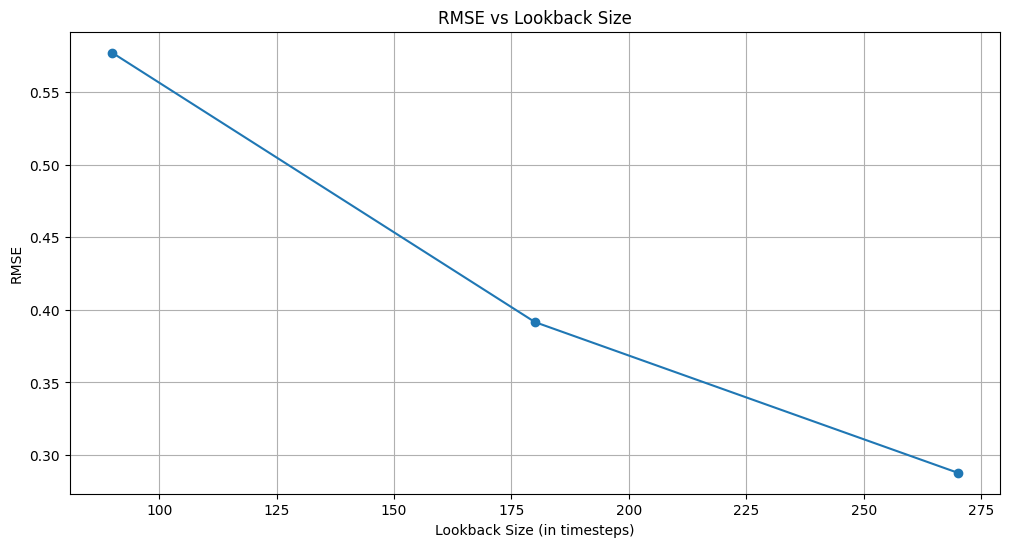

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(lookback_list, rmse_list, marker='o')
plt.title('RMSE vs Lookback Size')
plt.xlabel('Lookback Size (in timesteps)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

### $\color{green}{\text{Explanation/reasoning}}$ <br>

From the graph, a clear downward trend can be observed, indicating that as the lookback size increases, the RMSE decreases. This suggests that the model's predictions become more accurate when it has more past data points to consider. <br>

With a larger lookback size, the neural network has more past information, potentially capturing more of the underlying patterns in the data that are significant for making accurate predictions. <br>

The slope of the curve seems to be decreasing; while there is a steep decrease in RMSE going from a lookback size of around 90 to 180, the improvement from 180 to 270 has a slower rate. This could indicate that beyond a certain point, adding more past data doesn't contribute as much to improving model accuracy.


### Visualization of Actual and Predicted Path

* Modify and use same code from the previous parts. The time interval should be 6 seconds (choose from wherever in the testing data). Note that this time your model predicts 3 seconds. Think about how to deal with this.
* Generate a graph illustrating the actual and predicted paths using one of the above lookback sizes. Which one should you choose?

### Discussion

* How does changing the number of layers and neurons affect the error? Try out 3-4 reasonable combinations of these hyperparameters (i.e. evenly spaced enough to show some appreciable difference etc).

### Double click to $\color{green}{\text{add explanation/reasoning here}}$

# **Part 3B (Bonus Part): Mapping the Predicted Path onto the Video [5 marks]**

* Select the best-performing NN model from the ones you implemented above. Overlay the actual and predicted paths on the video frame. Sample is provided below.
* OpenCV documentation might be helpful for this task!

<video width="620" height="440" controls>
  <source src="./bonus_sample.mp4" type="video/mp4">
</video>

In [ ]:
# code here